In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 【問題1】全結合層のクラス化

In [2]:
class FC():
    def __init__(self, n_nodes1, n_nodes2, activator, initializer, optimizer):
        self.optimizer = optimizer
        self.activator = activator
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)

    def forward(self, X):  
        self.X = X
        self.n_batch = len(self.X)
        self.Z = np.dot(X, self.W) + self.B
        self.A = self.activator.forward(self.Z)
        return self.A    

    def backward(self, dA):
        dZ = self.activator.backward(dA)
        self, dA = self.optimizer.update(self, dZ)
        return dA

## 【問題2】初期方法のクラス化

## 【問題6】重みの初期値

In [3]:
class SimpleInitializer:
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        return np.random.randn(n_nodes1, n_nodes2)
    
    def B(self, n_nodes2):
        return np.random.randn(n_nodes2)
    
class XavierInitializer():
    def __init__(self):
        self.std = None
    
    def W(self, n_nodes1, n_nodes2):
        self.std = np.sqrt(n_nodes1)
        return np.random.randn(n_nodes1, n_nodes2) / self.std
    
    def B(self, n_nodes2):
        return np.random.randn(n_nodes2) / self.std
    

class HeInitializer():
    def __init__(self):
        self.std = None
    
    def W(self, n_nodes1, n_nodes2):
        self.std = np.sqrt(n_nodes1/2)
        return np.random.randn(n_nodes1, n_nodes2) / self.std
    
    def B(self, n_nodes2):
        return np.random.randn(n_nodes2) / self.std

## 【問題3】最適化手法のクラス化

## 【問題7】最適化手法

In [4]:
class SGD:
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer, dZ):
        dB = np.sum(dZ, axis=0)
        dW = np.dot(layer.X.T, dZ)
        dA = np.dot(dZ, layer.W.T)
        layer.B -= self.lr * dB / layer.n_batch
        layer.W -= self.lr * dW / layer.n_batch
        return layer, dA
    
class AdaGrad():
    def __init__(self, lr):
        self.lr = lr
        self.Hb = 1e-10
        self.Hw = 1e-10
        
    def update(self, layer, dZ):
        dB = np.sum(dZ, axis=0)
        dW = np.dot(layer.X.T, dZ)
        dA = np.dot(dZ, layer.W.T)
        self.Hb += (dB/layer.n_batch)**2
        self.Hw += (dW/layer.n_batch)**2
        layer.B -= self.lr * (self.Hb)**(-0.5) * dB / layer.n_batch
        layer.W -= self.lr * (self.Hw)**(-0.5) * dW / layer.n_batch
        return layer, dA

## 【問題4】活性化関数のクラス化

In [5]:
class Softmax():
    def __init__(self):
        pass
    
    def forward(self, Z):
        if Z.ndim == 2:
            Z = Z.T
            self.A = (np.exp(Z) / np.sum(np.exp(Z), axis=0)).T
            return self.A
        self.A = np.exp(Z) / np.sum(np.exp(Z))
        return self.A
    
    def backward(self, y):
        return self.A - y

## 【問題5】ReLUクラスの作成

In [6]:
class Relu():
    def __init__(self):
        pass
    
    def forward(self, Z):
        self.A = np.maximum(0, Z)
        return self.A
    
    def backward(self, dA):
        return  dA * np.where(self.A>0, 1, 0)

## 【問題8】クラスの完成

In [7]:
class ScratchDeepNeuralNetworkClassifier():
    def __init__(self, *layers, epoch=3):
        self.epoch = epoch
        self.n_layers = len(layers)
        self.layers = layers
        self.loss_train = []
        self.loss_valid = []

    def train(self, X, y, X_val=None, y_val=None):
        get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=20)
        for _ in tqdm(range(self.epoch)):
            for mini_X_train, mini_y_train in get_mini_batch:
                fout = mini_X_train.copy()
                for layer in self.layers:
                    fout = layer.forward(fout)

                bout = mini_y_train.copy()
                for layer in self.layers[::-1]:
                    bout = layer.backward(bout)
                    
            self.loss_train.append(self.crossentropy(mini_y_train, fout))
            if X_val is not None:
                y_val_pred = X_val.copy()
                for layer in self.layers:
                    y_val_pred = layer.forward(y_val_pred)
                self.loss_valid.append(self.crossentropy(y_val, y_val_pred))
        
        
    def crossentropy(self, y, y_pred):
        loss = -np.mean(np.sum(y*np.log(y_pred), axis=1))
        return loss
    
            
    def predict(self, X_test):
        out = X_test
        for layer in self.layers:
            out = layer.forward(out)
        return out      

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.datasets import mnist
from tqdm import tqdm

Using TensorFlow backend.


In [9]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

In [10]:
class GetMiniBatch:
    def __init__(self, X, y, batch_size=20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self, item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

## 【問題9】学習と推定

In [11]:
relu = Relu()
softmax = Softmax()
initializer = SimpleInitializer(sigma=1)
optimizer1 = SGD(lr=0.001)
optimizer2 = SGD(lr=0.001)
fc1 = FC(784, 200, relu, initializer, optimizer1)
fc2 = FC(200, 10, softmax, initializer, optimizer2)

nn = ScratchDeepNeuralNetworkClassifier(fc1, fc2, epoch=100)
nn.train(X_train, y_train, X_val=X_val, y_val=y_val)

y_pred = nn.predict(X_val)
print(accuracy_score(np.argmax(y_pred, axis=1), np.argmax(y_val, axis=1)))

100%|██████████| 100/100 [04:33<00:00,  2.73s/it]

0.9226666666666666


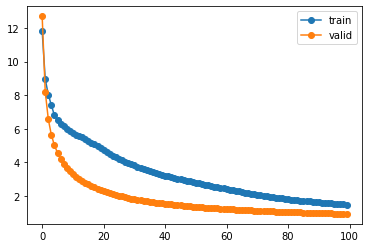

In [12]:
plt.plot(nn.loss_train, '-o', label='train')
plt.plot(nn.loss_valid, '-o', label='valid')
plt.legend();

In [13]:
relu = Relu()
softmax = Softmax()
initializer1 = SimpleInitializer(sigma=1)
initializer2 = SimpleInitializer(sigma=1)
optimizer1 = AdaGrad(lr=0.001)
optimizer2 = AdaGrad(lr=0.001)
fc1 = FC(784, 200, relu, initializer1, optimizer1)
fc2 = FC(200, 10, softmax, initializer2, optimizer2)

nn = ScratchDeepNeuralNetworkClassifier(fc1, fc2, epoch=100)
nn.train(X_train, y_train, X_val=X_val, y_val=y_val)

y_pred = nn.predict(X_val)
print(accuracy_score(np.argmax(y_pred, axis=1), np.argmax(y_val, axis=1)))

100%|██████████| 100/100 [23:28<00:00, 14.09s/it]

0.8269166666666666


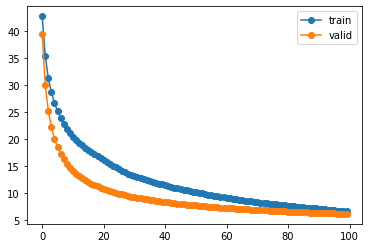

In [14]:
plt.plot(nn.loss_train, '-o', label='train')
plt.plot(nn.loss_valid, '-o', label='valid')
plt.legend();

In [15]:
relu = Relu()
softmax = Softmax()
initializer1 = XavierInitializer()
initializer2 = XavierInitializer()
optimizer1 = SGD(lr=0.001)
optimizer2 = SGD(lr=0.001)
fc1 = FC(784, 200, relu, initializer1, optimizer1)
fc2 = FC(200, 10, softmax, initializer2, optimizer2)

nn = ScratchDeepNeuralNetworkClassifier(fc1, fc2, epoch=100)
nn.train(X_train, y_train, X_val=X_val, y_val=y_val)

y_pred = nn.predict(X_val)
print(accuracy_score(np.argmax(y_pred, axis=1), np.argmax(y_val, axis=1)))

100%|██████████| 100/100 [04:38<00:00,  2.79s/it]

0.9554166666666667


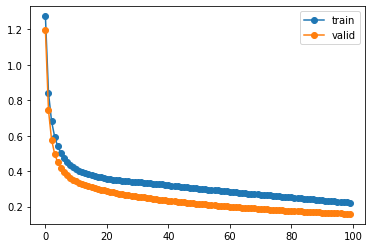

In [16]:
plt.plot(nn.loss_train, '-o', label='train')
plt.plot(nn.loss_valid, '-o', label='valid')
plt.legend();

In [17]:
relu = Relu()
softmax = Softmax()
initializer1 = HeInitializer()
initializer2 = HeInitializer()
optimizer1 = SGD(lr=0.001)
optimizer2 = SGD(lr=0.001)
fc1 = FC(784, 200, relu, initializer1, optimizer1)
fc2 = FC(200, 10, softmax, initializer2, optimizer2)

nn = ScratchDeepNeuralNetworkClassifier(fc1, fc2, epoch=100)
nn.train(X_train, y_train, X_val=X_val, y_val=y_val)

y_pred = nn.predict(X_val)
accuracy_score(np.argmax(y_pred, axis=1), np.argmax(y_val, axis=1))

100%|██████████| 100/100 [04:31<00:00,  2.71s/it]


0.9574166666666667

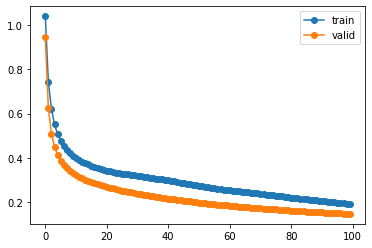

In [18]:
plt.plot(nn.loss_train, '-o', label='train')
plt.plot(nn.loss_valid, '-o', label='valid')
plt.legend();

In [19]:
relu1 = Relu()
relu2 = Relu()
relu3 = Relu()
softmax = Softmax()
initializer1 = XavierInitializer()
initializer2 = XavierInitializer()
initializer3 = XavierInitializer()
initializer4 = XavierInitializer()
optimizer1 = SGD(lr=0.001)
optimizer2 = SGD(lr=0.001)
optimizer3 = SGD(lr=0.001)
optimizer4 = SGD(lr=0.001)
fc1 = FC(784, 200, relu1, initializer1, optimizer1)
fc2 = FC(200, 200, relu2, initializer2, optimizer2)
fc3 = FC(200, 100, relu3, initializer3, optimizer3)
fc4 = FC(100, 10, softmax, initializer4, optimizer4)

nn = ScratchDeepNeuralNetworkClassifier(fc1, fc2, fc3, fc4, epoch=100)
nn.train(X_train, y_train, X_val=X_val, y_val=y_val)

y_pred = nn.predict(X_val)
print(accuracy_score(np.argmax(y_pred, axis=1), np.argmax(y_val, axis=1)))

100%|██████████| 100/100 [06:49<00:00,  4.10s/it]

0.9733333333333334


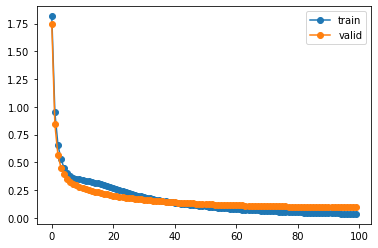

In [20]:
plt.plot(nn.loss_train, '-o', label='train')
plt.plot(nn.loss_valid, '-o', label='valid')
plt.legend();